In [1]:
%load_ext autoreload
%autoreload 2

import pymdp
from pymdp.jax.envs.generalized_tmaze import GeneralizedTMaze, GeneralizedTMazeEnv

import numpy as np 
import jax.random as jr 
import jax.numpy as jnp

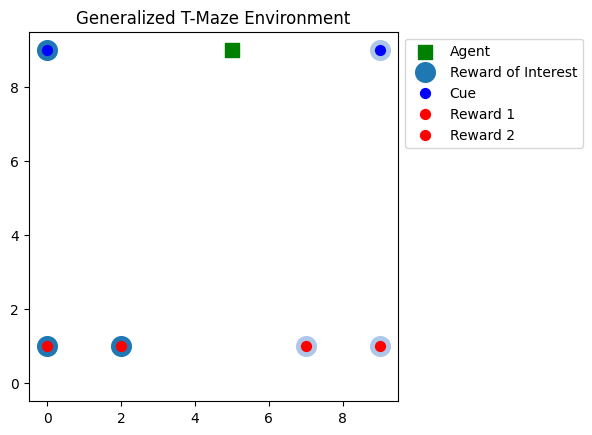

In [2]:
M = np.zeros((10, 10))
M[1,0] = 4
M[1,2] = 5
M[1,7] = 7
M[1,9] = 8
M[9,0] = 3
M[9,9] = 6
M[9,5] = 1
env = GeneralizedTMaze(M)
env.render()


tmaze_env = GeneralizedTMazeEnv(M)

In [3]:
import jax.tree_util as jtu 

jtu.tree_map(lambda x: print(x.shape), tmaze_env.params)

(1, 100, 100)
(1, 3, 100, 2)
(1, 3, 100, 2)
(1, 3, 100, 2)
(1, 3, 100, 2)
(1, 100, 100, 4)
(1, 2, 2, 1)
(1, 2, 2, 1)
(1, 100)
(1, 2)
(1, 2)


{'A': [None, None, None, None, None],
 'B': [None, None, None],
 'D': [None, None, None]}

In [4]:
batch_size = 1
seed = 0 
key = jr.PRNGKey(seed)

key, *subkeys = jr.split(key, batch_size + 1)
subkeys = jnp.array(subkeys)

tmaze_env.step(subkeys)

([Array([95], dtype=int32),
  Array([0], dtype=int32),
  Array([0], dtype=int32),
  Array([0], dtype=int32),
  Array([0], dtype=int32)],
 GeneralizedTMazeEnv(
   params={
     'A':
     [
       f32[1,100,100],
       f32[1,3,100,2],
       f32[1,3,100,2],
       f32[1,3,100,2],
       f32[1,3,100,2]
     ],
     'B':
     [f32[1,100,100,4], f32[1,2,2,1], f32[1,2,2,1]],
     'D':
     [f32[1,100], f32[1,2], f32[1,2]]
   },
   state=[i32[1], i32[1], i32[1]],
   dependencies={
     'A':
     [[0], [0, 1], [0, 2], [0, 1], [0, 2]],
     'B':
     [[0], [1], [2]]
   }
 ))

In [5]:
from pymdp.jax.agent import Agent

A = [a.copy() for a in tmaze_env.params["A"]]
B = [b.copy() for b in tmaze_env.params["B"]]
A_dependencies = tmaze_env.dependencies["A"]
B_dependencies = tmaze_env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]

agent = Agent(A, B, C, D, None, None, None, A_dependencies=A_dependencies, B_dependencies=B_dependencies)

In [6]:
obs, _ = tmaze_env.step(subkeys)

qs = [jnp.broadcast_to(d, (1,) + d.shape) for d in D]

qpi, nefe = agent.infer_policies(qs)

In [7]:
batch_size = 1
key, *subkeys = jr.split(key, batch_size + 1)
actions = agent.sample_action(qpi, rng_key=jnp.array(subkeys))


key, *subkeys = jr.split(key, batch_size + 1)
obs, _ = tmaze_env.step(jnp.array(subkeys), actions)

In [8]:
obs_b = [jnp.broadcast_to(o, (1,) + o.shape) for o in obs]
prior, _ = agent.update_empirical_prior(actions, qs)
res = agent.infer_states(obs_b, None, prior, None)

In [9]:
from pymdp.jax.envs.rollout import rollout

rollout(agent, tmaze_env, num_timesteps=5, batch_size=1, rng_key=key)

({'action_t': Array([[0, 0, 0]], dtype=int32),
  'empirical_prior': [Array([[1.11022594e-16, 2.22045187e-16, 1.11022594e-16, 2.22045187e-16,
           2.22045187e-16, 2.22045187e-16, 2.22045187e-16, 1.11022594e-16,
           2.22045187e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022594e-16, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.24999985e-01, 1.11022594e-16, 1.11022594e-16,
           1.11022594e-16, 1.11022

In [10]:
tmaze_env 

GeneralizedTMazeEnv(
  params={
    'A':
    [
      f32[1,100,100],
      f32[1,3,100,2],
      f32[1,3,100,2],
      f32[1,3,100,2],
      f32[1,3,100,2]
    ],
    'B':
    [f32[1,100,100,4], f32[1,2,2,1], f32[1,2,2,1]],
    'D':
    [f32[1,100], f32[1,2], f32[1,2]]
  },
  state=[i32[1], i32[1], i32[1]],
  dependencies={
    'A':
    [[0], [0, 1], [0, 2], [0, 1], [0, 2]],
    'B':
    [[0], [1], [2]]
  }
)

In [11]:
idx = env.position_to_index((3, 7))
print(idx)
pos = env.index_to_position(idx)
print(pos)

37
(3, 7)
